#### Generative Adversarial Networks (GANs)

GANs is a method for training generative models that was proposed in 2014 by Goodfellow et al. There are two neural networks in a GAN. One is called the generator which takes a random noise as input and outputs an image. The other is called the discriminator which is a binary classifier to classify whether an input image is a real image or a fake image generated by the generator. The goal of the generator is to generate images that can fool the discriminator into thinking the images are real.

This iterative process of generator trying to fool the discriminator and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are random noise vectors,  $G(z)$ are the fake images generated by the generator $G$, $D$ is a probability of the input of the discriminator being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

In practice, for the objective of the generator, instead of minimizing the following objection:
$$\underset{G}{\text{minimize}}\; \left[\log \left(1-D(G(z))\right)\right]$$
We use a different objective for the generator: maximizing the probability of the disciminator being fooled. 

$$\underset{G}{\text{maximize}}\; \left[\log \left(D(G(z))\right)\right]$$

This helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

## Setup

In [1]:

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
from torchvision import transforms, datasets ,utils


 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

answers = np.load('gan-checks-tf.npz')
print('Done')

Done


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Hint: use `torch.rand`.

In [2]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    ###############
    ##1st TO DO (4 points)
    #################
    noise = torch.rand(batch_size, dim)*2-1

    return noise



Make sure noise is the correct shape and type:

In [3]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


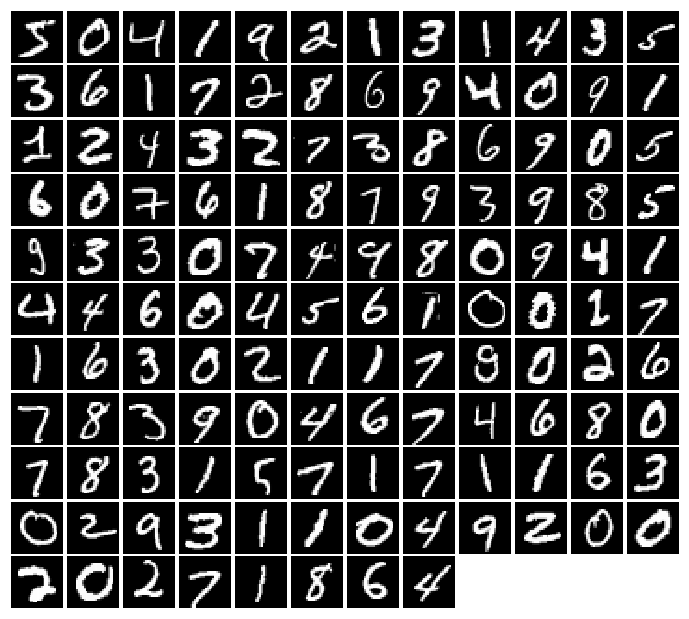

In [4]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 100
batch_size = 128

mnist_train = dset.MNIST('./data/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./data/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Flatten

Flatten makes each image in a batch as a one dimentional vector. Unflatten makes each one dimentional vector in a batch as an image, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform(m.weight.data)

## CPU / GPU
By default all code will run on CPU. GPUs are not needed for this assignment, but will help you to train your models faster. If you do want to run the code on a GPU, then change the `dtype` variable in the following cell.

In [6]:
# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!


#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* 36 Filters, 4x4, Stride 1, Leaky ReLU(alpha=0.02)
* Max Pool 2x2, Stride 2
* 72 Filters, 4x4, Stride 1, Leaky ReLU(alpha=0.02)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 1024, Leaky ReLU(alpha=0.02)
* Fully Connected size 1

In [7]:
def build_dc_classifier():#mnist
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        ###########################
        #########2nd TO DO (10 points)###########
        ###########################
        Unflatten(batch_size, 1, 28, 28),        
        nn.Conv2d(1, 36, kernel_size=4, stride=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(36, 72, kernel_size=4, stride=1),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(1152,1024),
        nn.LeakyReLU(negative_slope=0.02, inplace=True),
        nn.Linear(1024,1)
    )

Check the number of parameters in your classifier as a sanity check:

In [8]:
def test_dc_classifer(true_count=1223853):
    model = build_dc_classifier()
    cur_count = count_params(model)
    if cur_count != true_count:
        print(cur_count)
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


#### Generator.
See the document for documentation for [ConvTranspose2d](http://pytorch.org/docs/master/nn.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d). 

* Fully connected of size 1500, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 120, ReLU
* BatchNorm
* Reshape into Image Tensor using Unflatten(), you should figure out the parameters of N,C,H and W.
* 60 ConvTranspose2d filters of 4x4, stride 2,  padding=1, ReLU
* BatchNorm
* 1 ConvTranspose2d filter of 4x4, stride 2, padding=1, TanH
* Should have a 28x28x1 image, reshape back into 784 vector

In [9]:
def build_dc_generator(noise_dim=NOISE_DIM):#mnist
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        #########3rd TO DO (10 points)###########
        nn.Linear(noise_dim, 1500),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1500),
        nn.Linear(1500, 5880),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(5880),
        Unflatten(batch_size, 120, 7, 7),
        nn.ConvTranspose2d(120, 60, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(60),
        nn.ConvTranspose2d(60, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()
    )

Check the number of parameters in your generator as a sanity check:

In [10]:
def test_dc_generator(true_count=9108481):
    model = build_dc_generator(100)
    cur_count = count_params(model)
    if cur_count != true_count:
        print(cur_count)
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = y * \log(s) + (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:


`true_labels = Variable(torch.ones(size)).type(dtype)`

Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Variable of shape (N, ) giving scores.
    - target: PyTorch Variable of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Variable containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()



In [12]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    ##########4th TO DO (5 points)#############
    true_labels = Variable(torch.ones(logits_real.shape[0])).type(dtype)
    fake_labels = Variable(torch.zeros(logits_fake.shape[0])).type(dtype)
    loss1 = bce_loss(logits_real, true_labels)
    loss2 = bce_loss(logits_fake, fake_labels)
    loss = loss1 + loss2
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    #-log(1 / (1 + exp(-x)))
    #####5th TO DO (3 points)########
    labels = Variable(torch.ones(logits_fake.shape[0])).type(dtype)
    loss=bce_loss(logits_fake, labels)
  
    return loss

Test your generator and discriminator loss. You should see errors < 1e-7.

In [13]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(Variable(torch.Tensor(logits_real)).type(dtype),
                                Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 0


In [14]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(Variable(torch.Tensor(logits_fake)).type(dtype)).data.cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 3.86398e-08


# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 2e-3 learning rate, beta1=0.6, beta2=0.9999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [15]:

def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    #########6th TO DO (3 points)###############
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))  
    return optimizer

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it. 

In [16]:
import time
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=100, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    t1=time.time()
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            t2=time.time()
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = Variable(x).type(dtype)
            real_data=real_data.view(batch_size,1,784)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)
            fake_images=fake_images.detach()
            
            logits_fake = D(fake_images.view(batch_size, 1, 784))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = Variable(sample_noise(batch_size, noise_size)).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 784))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.data[0],g_error.data[0]))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print
#                 print('total time: %.2f'%(time.time()-t1))
#                 print('100 iter time: %.2f'%(time.time()-t2))
#                 print()
            iter_count += 1

This would takes about 1 hour on one cpu. In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

start training
Iter: 0, D: 1.446, G:0.4913


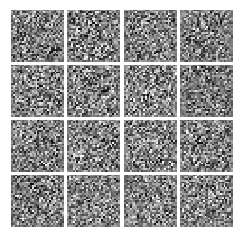

Iter: 250, D: 1.422, G:0.6271


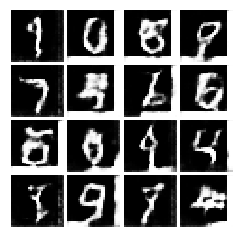

Iter: 500, D: 1.162, G:0.9663


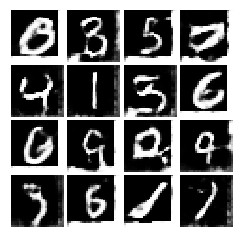

Iter: 750, D: 1.155, G:1.034


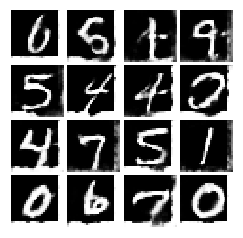

Iter: 1000, D: 1.295, G:0.8387


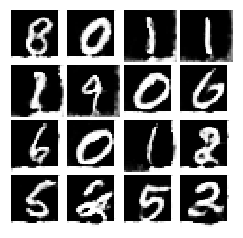

Iter: 1250, D: 1.224, G:1.052


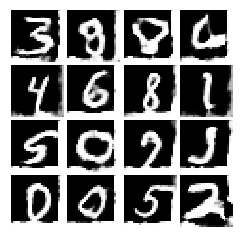

Iter: 1500, D: 1.159, G:1.029


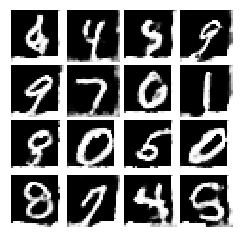

Iter: 1750, D: 1.151, G:0.9579


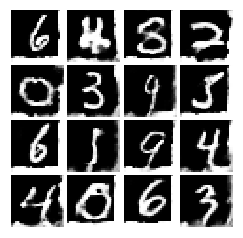

Iter: 2000, D: 1.143, G:0.8007


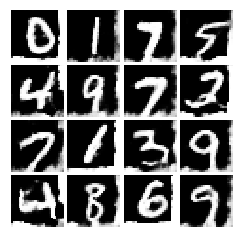

Iter: 2250, D: 1.453, G:0.57


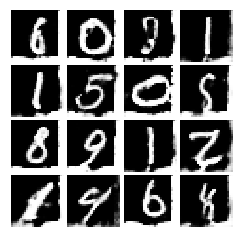

Iter: 2500, D: 1.133, G:1.635


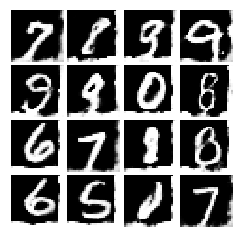

Iter: 2750, D: 0.9005, G:0.9286


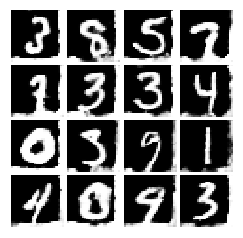

Iter: 3000, D: 1.085, G:1.293


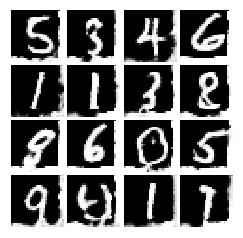

Iter: 3250, D: 0.9428, G:1.187


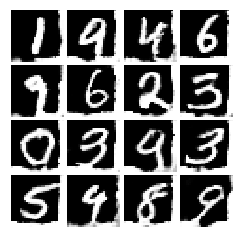

Iter: 3500, D: 0.9438, G:1.597


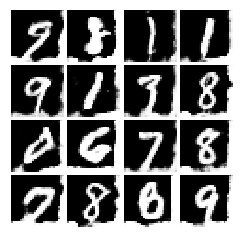

Iter: 3750, D: 0.8892, G:0.8307


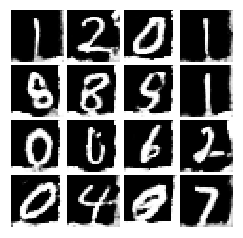

In [17]:
# Make the discriminator
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
# Make the generator
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)
# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)
t1=time.time()
print('start training')
# Run it!
run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=10)
# print(time.time()-t1)

#### Inline Question
1.Exaplain how the ditribution of images change through iterations. (1 point)
2.Explain why the loss of D cannot converge to around 0? 
What would happen if loss of D is very small and loss of G is very large at the end of training? Is this a prefered situation for generating images that look real? (3 points)

###7th TO DO: write your answer here (5 points) ######

1. The images are initially very Noisy. They start looking realistic at around 250 iterations. Then they appear accurate after 3000 iterations

2. (i) Loss of Discriminator cannot converge to 0 as it is counterintuitive. If it becomes zero, then it will always discriminate images properly, and the generator wont be trained.

   (ii) If the loss of the Discriminator is very small, and loss of Generator is very large at the end of training, then the Discriminator becomes perfect (always able to correctly tell if image is real or fake), however, as the loss of the Generator is high, it is not able to generate real looking images. So, it is never able to fool the Discriminator.

   (iii) This is not a prefered situation for generating images as we would always get unrealistic images.